In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read csv

In [306]:
def read_csv():
    # return: numpy array of f, h, c, list(I), list(J)
    # f is the fixed cost vector, f.shape = (nJ,)
    # h is the demand vector, h.shape = (nI,)
    # c is the transportation matrix, c.shape = (nI,nJ)
    r = 3958.76
    customer_table = pd.read_excel('toy-stores.xlsx', 'customer')
    facility_table = pd.read_excel('toy-stores.xlsx', 'candidate')
    # first, we get data from tables and store them in numpy array
    # and calculate the distance cost for each customer
    nI = customer_table.shape[0]
    nJ = facility_table.shape[0]
    c = np.zeros([nI, nJ])
    h = customer_table['Demand (pallets)'].values
    f = facility_table['Fixed Cost'].values
    for i in range(nI):
        for j in range(nJ):
            alpha1 = np.deg2rad(customer_table.loc[i, 'Lat'])
            alpha2 = np.deg2rad(facility_table.loc[j, 'Lat'])
            delta_alpha = alpha1 - alpha2
            delta_beta = np.deg2rad(customer_table.loc[i, 'Lon'] - facility_table.loc[j, 'Lon'])
            c[i, j] = 2. * r * np.arcsin(np.sqrt(
                (np.sin(delta_alpha / 2)) ** 2. + np.cos(alpha1) * np.cos(alpha2) * ((np.sin(delta_beta / 2)) ** 2.)))
    return f, h, c, list(range(nI)), list(range(nJ))

TODO1. complete dual functions

In [ ]:
def dual_func_relax_assignment(lamb, c, h, f):
    
    # input lamb.shape = (nI,) c.shape = (nI, nJ), h.shape=(nI,), f.shape=(nJ,)
    
    # TODO: your code here, solve LR subproblems when relaxing assignment constraints
    x=np.zeros(len(f)) #j
    y=np.zeros((len(h),len(f))) #i,j
    sub_grad=np.zeros(len(h)) #i

    x = (f - np.sum(np.maximum(0, lamb[:, None] - h[:, None] * c), axis=0) < 0).astype(int)

    
    for i in range(len(h)):
        for j in range(len(f)):
            if h[i]*c[i,j]-lamb[i]<0 and x[j]==1:
                y[i,j]=1
    
    for i in range(len(h)):
        sub_grad[i]=1-sum(y[i,:])
    
    dual_val=sum([f[j]*x[j] for j in range(len(f))])+sum([h[i]*sum([c[i,j]*y[i,j] for j in range(len(f))]) for i in range(len(h))])
    dual_val+=sum([lamb[i]*sub_grad[i] for i in range(len(h))])
    # output: x.shape = (nJ), y.shape = (nI, nJ), sub_grad.shape=(nI,), dual_val: scaler, value of dual function
    return x,y, sub_grad, dual_val

def dual_func_relax_linking(lamb, c, h, f):
    # input lamb.shape = (nI, nJ) c.shape = (nI, nJ), h.shape=(nI,), f.shape=(nJ,)
    # TODO: your code here, solve LR subproblems when relaxing linking constraints
    x=np.zeros(len(f)) #j
    y=np.zeros((len(h),len(f))) #i,j
    sub_grad=np.zeros((len(h),len(f))) #i,j

    for j in range(len(f)):
        if f[j]-sum(lamb[:,j])<0:
            x[j]=1
    
    for i in range(len(h)):
        v=[h[i]*c[i,j]+lamb[i,j] for j in range(len(f))]
        ind=np.argmin(v)
        y[i,ind]=1
    
    for i in range(len(h)):
        for j in range(len(f)):
            sub_grad[i,j]=y[i,j]-x[j]
    #print(sub_grad)

    dual_val = sum([f[j]*x[j] for j in range(len(f))])+sum([h[i]*sum([c[i,j]*y[i,j] for j in range(len(f))]) for i in range(len(h))])
    dual_val += np.sum(lamb * sub_grad)

    # output: x.shape = (nJ), y.shape = (nI, nJ), sub_grad.shape=(nI,nJ), dual_val: scaler, value of dual function
    return x, y, sub_grad, dual_val

TODO 2. find an upper bound given open plan x and parameter c, h, f

In [308]:
def upper_bd(x, c, h, f):
    # input x.shape = (nJ,), c.shape = (nI, nJ), h.shape=(nI,), f.shape=(nJ,)
    
    # TODO: your code here, assign customers to nearest open facilities
     
    #get y, just assign each customer to the nearest facility that is open
    y=np.zeros((len(h),len(f)))
    for i in range(len(h)):
        v=[]
        for j in range(len(f)):
            if x[j]==1:
                v.append(c[i,j])
            else:
                v.append(np.inf)
        if min(v)<np.inf:
            ind=np.argmin(v)
        else: #no open facility!
            return 1194676922, None
        y[i,ind]=1
    #get upper bound
    ub=sum([f[j]*x[j] for j in range(len(f))])+sum([h[i]*sum([c[i,j]*y[i,j] for j in range(len(f))]) for i in range(len(h))])

    # output ub: the upper bound cost, y: assignment result, y.shape = (nI,nJ)
    return ub, y

TODO 3. define step length, impose dual feasiblility and update dual variables

In [309]:
def step_length_func(upper_bound, dual_val, sub_grad):
    # input: upper bound, dual function value, and sub gradient vector
    # TODO 3.1: calculate step length using the formula given in HW3, textbook or slides
    # return: a step_length 

    step_length = 0.5*(upper_bound-dual_val)/np.sum(sub_grad**2)
    return step_length

def solve_LR(lamb0, UB0, relax_constr = 'assignment'):
    # lamb0: numpy array of initial value of lamb, shape depends on how you relax 
    # UB0: value of initial optimal value
    # relax_constr in {'assignment','linking'}
    lamb = lamb0
    best_upper_bound = UB0
    ub = []
    lb = []
    # LR iterations
    for t in range(100):
        # calculate dual function
        if relax_constr == 'assignment':
            x_t, y_t, sub_grad, dual_val = dual_func_relax_assignment(lamb, c, h, f)
        elif relax_constr == 'linking':
            x_t, y_t, sub_grad, dual_val = dual_func_relax_linking(lamb, c, h, f)
        else:
            raise ValueError('input constraint doesnt exist')
        # use the open plan from dual function to find an upper bound
        upper_bound, y_t = upper_bd(x_t, c, h, f)
        # update the best upper bound
        if upper_bound<best_upper_bound:
            x_t_upper = x_t # keep a record of the best solution found so far
            y_t_upper = y_t
            best_upper_bound = upper_bound
        upper_bound = best_upper_bound
        # TODO 3.2.: calculate step length using (8.21) from textbook
        # your code here, you can use step_length function you just defined
        lamb += step_length_func(upper_bound, dual_val, sub_grad)*sub_grad
        # impose dual feasibility
        if relax_constr == 'linking':
            # TODO 3.3.: if we relax inequalities, we need to satisfy dual feasibility
            # your code here
            for i in range(len(h)):
                for j in range(len(f)):
                    lamb[i,j]=max(0,lamb[i,j])
                    
        # stopping conditions
        dt = upper_bound - dual_val
        #print('iter',t,'upper:',upper_bound,'dual func:',dual_val, 'gap',dt)
        nJ = len(f)
        if dt < 1e-2: 
            print('solution found:',np.arange(1,nJ+1)[x_t>0])
            break
        lb.append(dual_val) #record lb and ub for each iteration
        ub.append(best_upper_bound)
        
        print('-'*30)
        print('iter',t,'upper:',upper_bound,'dual func:',dual_val, 'gap',upper_bound-dual_val)
        print('open facility:',np.arange(1,len(J)+1)[x_t>0])
    return ub, lb, x_t_upper, y_t_upper

def plot_ub_lb(ub, lb):
    # plot the result
    plt.figure()
    plt.plot(ub, label='ub')
    plt.plot(lb, label='lb')
    plt.xlabel('iters')
    plt.legend()
    plt.show()

TODO 4: define step length function

In [310]:
f, h, c, I, J = read_csv()

# initialize
UB0 = 1194676922

part b:
------------------------------
iter 0 upper: 1194676922 dual func: 205403559.20568016 gap 989273362.7943199
open facility: []
------------------------------
iter 1 upper: 453367267.18192244 dual func: 196202766.45980138 gap 257164500.72212106
open facility: [ 5  8 10 12 13 24]
------------------------------
iter 2 upper: 453367267.18192244 dual func: 217538499.07448924 gap 235828768.1074332
open facility: [ 5  8 10 12 13 24]
------------------------------
iter 3 upper: 453367267.18192244 dual func: 234847096.29827574 gap 218520170.8836467
open facility: [ 5  8 10 12 13 24]
------------------------------
iter 4 upper: 453367267.18192244 dual func: 250425806.96825725 gap 202941460.2136652
open facility: [ 5  8 10 12 13 24]
------------------------------
iter 5 upper: 453367267.18192244 dual func: 264143680.9474463 gap 189223586.23447615
open facility: [ 5  8 10 12 13 24]
------------------------------
iter 6 upper: 453367267.18192244 dual func: 275702531.5577631 gap 177664735.624

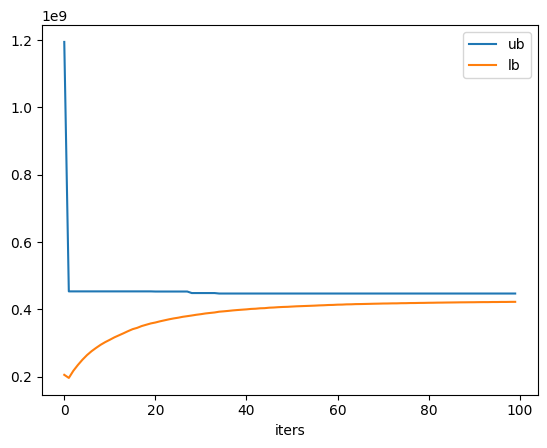

In [311]:
# for problem (b)
print('part b:')
lamb0 = 1.*np.ones((len(I),len(J)))
ub,lb,x,y = solve_LR(lamb0, UB0, relax_constr = 'linking')
plot_ub_lb(ub, lb)

part c:
open: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
------------------------------
iter 0 upper: 1194676922 dual func: 100.0 gap 1194676822.0
open facility: []
open: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]
------------------------------
iter 1 upper: 921590744.0584431 dual func: -449826097.66147995 gap 1371416841.719923
open facility: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 22 23 24]
open: [0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1]
------------------------------
iter 2 upper: 700324524.7820451 dual func: 48504927.77044368 gap 651819597.0116014
open facility: [ 4  5  7  8 10 11 12 13 14 15 16 17 18 22 23 24]
open: [0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1]
------------------------------
iter 3 upper: 497285662.61387753 dual func: 265848186.3594622 gap 231437476.25441533
open facility: [ 5  8 10 12 13 14 15 16 17 23 24]
open: [0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1]
------------------------------
iter 4 upper: 497285662.61387

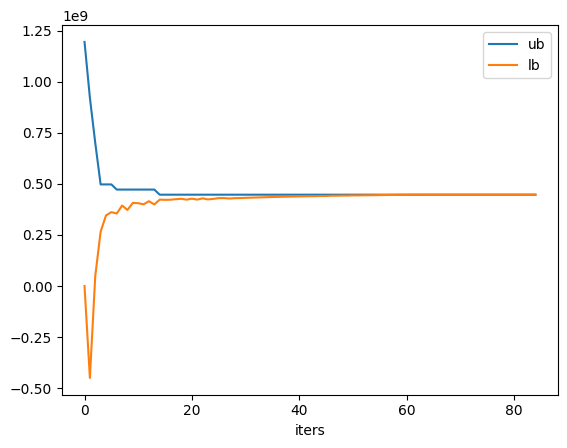

In [312]:
# for problem (c)
print('part c:')
lamb0 = 1.*np.ones(len(I))
ub,lb,x,y = solve_LR(lamb0, UB0, relax_constr = 'assignment')
plot_ub_lb(ub, lb)